In [10]:
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shelve

x_size, y_size = 85, 15
# data.keys()  # dict_keys(['ligand_len', 'pi', 'd', 'mean', 'sigma', 'vdw_pair', 'hbond_pair'])
pdbs = ['6ggb']
root = 'dock_results/energy_timetest/gaussian_predict'

dict_keys(['ligand_len', 'pocket_len', 'pi', 'mean', 'sigma', 'hbond_pair', 'hydro_pair', 'd', 'vdw_pair'])
ligand_len:23, pocket_len:186


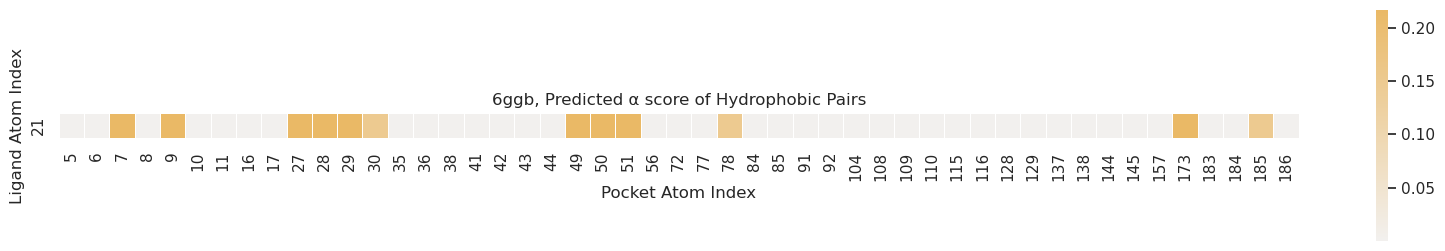

In [11]:
import pandas as pd

target_ligand_atom_idx = 20  # 20=hydro


def draw_heat(df, type_name):
    # data frame
    df = df.pivot(index="x", columns="pocket", values="pi")
    df.index.name = 'Ligand Atom Index'
    df.columns.name = 'Pocket Atom Index'
    ###
    # color
    if type_name == 'hbond':
        color = sns.light_palette('#FEED62', reverse=False, as_cmap=True)  # hbond
    else:
        color = sns.light_palette('#EAB966', reverse=False, as_cmap=True)  # hydro

    # draw
    fig, ax = plt.subplots(figsize=(20, 3))
    sns.set(font_scale=1.)
    ax = sns.heatmap(df, cmap=color, ax=ax, linewidths=.5, square=True,
                     cbar=True)  # mako=hbond, flare=hydro  # , annot=True, fmt='.1f'
    ####
    ax.set_facecolor('black')
    #ax.set_ylabel('')
    if type_name == 'hbond':
        ax.set_title(f'{pdb}, Predicted α score of Hydrogen Bonds Pairs')
    else:
        ax.set_title(f'{pdb}, Predicted α score of Hydrophobic Pairs')
    


for pdb in pdbs:
    # read data
    abspath_pkl_normalscore = f'{root}/{pdb}_G.db'
    with shelve.open(abspath_pkl_normalscore) as db:
        data = db['0']
    print(data.keys())
    ln = int(data['ligand_len'][0])
    pocket_len = int(data['pocket_len'][0])
    inter_mask = (slice(0, ln), slice(ln, None))
    d = data['d'][inter_mask]
    hbond_pair = data['hbond_pair'][inter_mask]
    hydro_pair = data['hydro_pair'][inter_mask]
    pi = data['pi'][inter_mask]
    # select hBond-ligand
    I, J, _ = np.where((hbond_pair == 1) | (hydro_pair == 1))
    all_data = []
    print(f"ligand_len:{ln}, pocket_len:{pocket_len}")
    IsHBond = False
    for i, j in zip(I, J):
        name_i, name_j = i + 1, j + 1
        if i == target_ligand_atom_idx:
            if hydro_pair[i, j]:
                all_data.append([name_i, name_j, pi[i, j, 2], 'hydro'])
                if d[i, j] < 2.:
                    # magically increase the color of it
                    all_data[-1][2] += 0.15

    ###
    df = pd.DataFrame(all_data, columns=['x', 'pocket', 'pi', 'type'])
    draw_heat(df, type_name='hbond' if IsHBond else 'hydro')
    # break
    plt.show()
# df